# 1.Introduction

Ce notebook reconstruit proprement l’ensemble du pipeline d’apprentissage du 
modèle analytique utilisé pour prédire **le temps minimal à partir duquel les 
piétons cessent de traverser** dans l’Expérience 2.

Ce temps est dérivé de la donnée comportementale :

$$
\text{avg\_safety\_time} = 
\frac{\text{avg\_safety\_distance}}{\text{velocity\_ms}}
$$

Il correspond au **seuil temporel empirique de non-traversée** observé dans l’expérience.


##  Objectifs du notebook

1. Charger et concaténer les données de l’Expérience 2 (9 CSV météo × vitesse).
2. Calculer les variables comportementales :
   - vitesse convertie en m/s  
   - temps minimal de sécurité (`avg_safety_time`)
3. Construire les features explicatives du modèle :
   - `height`
   - `height^2`
   - `velocity_exp2`
4. Entraîner un modèle linéaire global prédisant `avg_safety_time`.
5. Estimer des coefficients multiplicateurs météo (`alpha_weather`) pour :
   - `clear`, `rain`, `night`
6. Introduire un *biais comportemental* basé sur l’erreur de prédiction :
   - moyenne des erreurs $\mu$
   - écart-type des erreurs $\sigma$
   - ajustement :
     
     $$
     y_{\text{adjusted}} = y_{\text{pred}} - 2\sigma + \mu
     $$
     
   afin d’assurer un modèle plus prudent et plus robuste.
7. Entraîner un modèle final complet (coefficients + alphas + biais).
8. Évaluer les performances (MAE, RMSE, R²).
9. Générer les visualisations nécessaires à la thèse.
10. Exporter les paramètres finaux dans un fichier YAML.


##  Structure scientifique du modèle

Le modèle final estime pour chaque condition météo **le temps minimal de non-traversée** comme :

$$
T_{end}=
\alpha_{weather}
\left(
a \cdot \text{height}
+ b \cdot \text{height}^{2}
+ c \cdot \text{velocity}
+ \text{intercept}
\right)
$$

où :

- $ a, b, c $ et l’intercept sont appris via régression linéaire globale,  
- $\alpha_{weather}$ corrige systématiquement le modèle selon la météo.

Ensuite, un *biais comportemental* est appliqué :

- On définit d'abord la moyenne des erreurs :
  
  $$
  \mu = \mathbb{E}[y_{\text{true}} - y_{\text{pred}}]
  $$

- Puis l’écart-type des erreurs :
  
  $$
  \sigma = 
  \sqrt{
  \mathbb{E}\left[(y_{\text{true}} - y_{\text{pred}} - \mu)^2\right]
  }
  $$

L’ajustement final devient :

$T_{end}^{adjusted} = T_{end} - 2 \sigma + \mu$

Cet ajustement rend le modèle **plus conservateur** :  
le modèle prédit un temps légèrement plus faible → le système considère plus tôt que le piéton ne traversera plus.


##  Données utilisées

Les données proviennent des fichiers :

```

data/processed/
┣ clear_high.csv
┣ clear_medium.csv
┣ clear_low.csv
┣ rain_high.csv
┣ rain_medium.csv
┣ rain_low.csv
┣ night_high.csv
┣ night_medium.csv
┣ night_low.csv

```

Chaque fichier contient :
- la hauteur du participant (`height`)
- la vitesse du véhicule (`velocity_exp2`)
- la distance moyenne de sécurité (`avg_safety_distance`)

Le but du modèle est de prédire **le temps minimal de non-traversée** en fonction :
- des caractéristiques du participant
- de la dynamique du véhicule
- et des conditions météo.


# 2.Chargement et préparation des données

In [ ]:
# ============================================
# Chargement et préparation des données
# ============================================

import pandas as pd
import numpy as np
from pathlib import Path

# Dossier contenant les 9 CSV météo × vitesses
DATA_FOLDER = Path("../../data/processed/")


# --------------------------------------------
# Fonction : charger tous les CSV du dossier
# --------------------------------------------
def load_csv_files(folder_path: Path) -> pd.DataFrame:
    """
    Charge tous les fichiers CSV du dossier `data/processed`
    et ajoute automatiquement la colonne 'weather' extraite
    du nom de fichier : <weather>_<condition>.csv

    Exemple :
        - clear_high.csv   → weather = 'clear'
        - rain_low.csv     → weather = 'rain'
        - night_medium.csv → weather = 'night'
    """

    all_files = [fp for fp in folder_path.iterdir() if fp.suffix == ".csv"]

    if len(all_files) == 0:
        raise FileNotFoundError(
            f"Aucun fichier CSV trouvé dans {folder_path.resolve()}"
        )

    datas = pd.DataFrame()

    for file in all_files:
        filename = file.name

        # extraire "clear", "rain" ou "night"
        if "_" in filename:
            weather = filename.split("_")[0]
        else:
            print(f" Fichier ignoré (mauvais format) : {filename}")
            continue

        df = pd.read_csv(file)
        df["weather"] = weather

        datas = pd.concat([datas, df], ignore_index=True)

    # Vérification météo détectée
    print(" Conditions météo chargées :", datas["weather"].unique())

    # Conversion vitesse (km/h → m/s)
    if "velocity_exp2" not in datas.columns:
        raise KeyError("La colonne 'velocity_exp2' est absente des CSV.")
    
    datas["velocity_ms"] = datas["velocity_exp2"] * (5.0 / 18.0)

    # Calcul du temps minimal avant non-traversée
    datas["avg_safety_time"] = datas["avg_safety_distance"] / datas["velocity_ms"]

    # Suppression des lignes incomplètes
    datas = datas.dropna()

    return datas


# ------------------------------------------------------------
#  Fonction : création des features polynomiales (height, v)
# ------------------------------------------------------------
def prepare_data(df: pd.DataFrame, limit: float | None = None) -> pd.DataFrame:
    """
    Ajoute les features polynomiales :
        - height^2, height^3, height^4
        - velocity_exp2^2, velocity_exp2^3, velocity_exp2^4
    
    Et filtre optionnellement les valeurs :
        avg_safety_time < limit
    """

    data = df.copy()

    if limit is not None:
        data = data[data["avg_safety_time"] < limit]

    # Puissances de height
    data["height^2"] = data["height"] ** 2
    data["height^3"] = data["height"] ** 3
    data["height^4"] = data["height"] ** 4

    # Puissances de velocity
    data["velocity_exp2^2"] = data["velocity_exp2"] ** 2
    data["velocity_exp2^3"] = data["velocity_exp2"] ** 3
    data["velocity_exp2^4"] = data["velocity_exp2"] ** 4

    return data


# ==========================================================
#  Chargement des données
# ==========================================================
print(" Chargement des données depuis :", DATA_FOLDER.resolve())

datas = load_csv_files(DATA_FOLDER)

print(f" Données chargées : {datas.shape[0]} lignes, {datas.shape[1]} colonnes")


# ==========================================================
#  Préparation des datasets (avec et sans filtrage)
# ==========================================================

# Dataset complet (toutes observations valides)
all_datas = prepare_data(datas)

# Dataset filtré pour améliorer la stabilité des modèles
# (on garde uniquement avg_safety_time < 7)
datas_until_7 = prepare_data(datas, limit=7)

print(f" Dataset filtré : {datas_until_7.shape[0]} lignes")

# Aperçu
datas_until_7.head()


📥 Chargement des données depuis : C:\Users\svictor\Documents\pedestrian-crossing-prediction\data\processed
 Conditions météo chargées : ['clear' 'night' 'rain']
 Données chargées : 168 lignes, 13 colonnes
 Dataset filtré : 150 lignes


,participant_id,avg_safety_distance,height,age,d_l,d_m,d_h,distance_category,velocity_exp1,velocity_exp2,weather,velocity_ms,avg_safety_time,height^2,height^3,height^4,velocity_exp2^2,velocity_exp2^3,velocity_exp2^4
0,XXX_43,48.783020,157,25,-12.202150,17.071533,-32.350967,odd,60,70,clear,19.444444,2.508841,24649,3869893,607573201,4900,343000,24010000
1,XXX_40,91.593208,161,26,-19.918000,-34.863283,-39.402067,odd,60,70,clear,19.444444,4.710508,25921,4173281,671898241,4900,343000,24010000
2,XXX_39,62.062988,190,26,-23.496700,-9.490967,-33.917549,odd,60,70,clear,19.444444,3.191811,36100,6859000,1303210000,4900,343000,24010000
3,XXX_36,64.247789,187,27,3.117067,3.191532,2.513218,pair,60,70,clear,19.444444,3.304172,34969,6539203,1222830961,4900,343000,24010000
4,XXX_34,35.943017,173,29,9.144283,55.509850,16.966347,pair,60,70,clear,19.444444,1.848498,29929,5177717,895745041,4900,343000,24010000


# 3.Définition des features et target

 Features utilisées : ['height', 'height^2', 'velocity_exp2']
 Target : avg_safety_time
 Colonne météo : weather

 Dimensions :
X : (150, 3)
y : (150,)


,height,height^2,velocity_exp2,avg_safety_time
count,150.000000,150.000000,150.000000,150.000000
mean,174.806667,30626.660000,47.333333,3.974038
std,8.351905,2907.464845,16.247526,1.288220
min,157.000000,24649.000000,20.000000,1.528349
25%,170.000000,28900.000000,32.500000,2.996569
50%,176.000000,30976.000000,50.000000,3.807512
75%,179.000000,32041.000000,60.000000,4.860905
max,190.000000,36100.000000,70.000000,6.607268


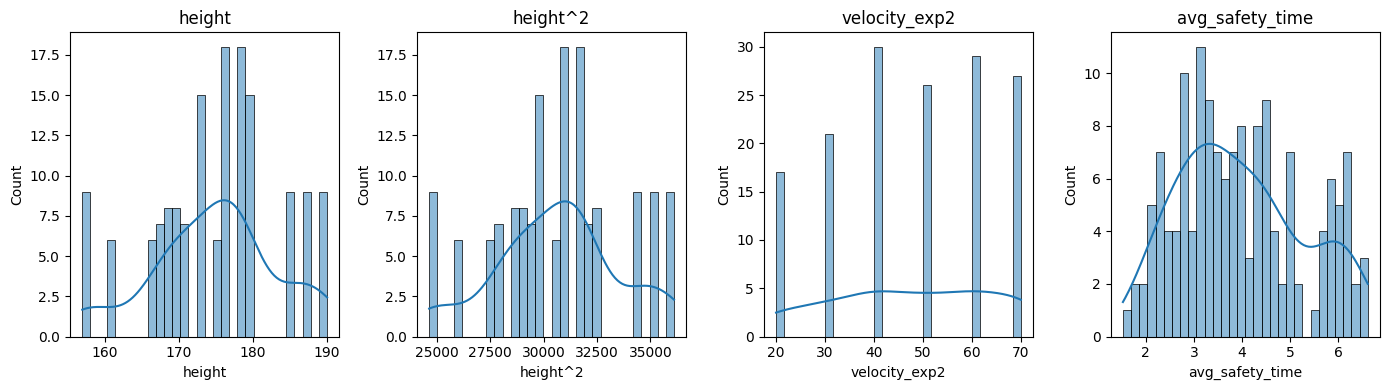

,participant_id,avg_safety_distance,height,age,d_l,d_m,d_h,distance_category,velocity_exp1,velocity_exp2,weather,velocity_ms,avg_safety_time,height^2,height^3,height^4,velocity_exp2^2,velocity_exp2^3,velocity_exp2^4
0,XXX_43,48.783020,157,25,-12.202150,17.071533,-32.350967,odd,60,70,clear,19.444444,2.508841,24649,3869893,607573201,4900,343000,24010000
1,XXX_40,91.593208,161,26,-19.918000,-34.863283,-39.402067,odd,60,70,clear,19.444444,4.710508,25921,4173281,671898241,4900,343000,24010000
2,XXX_39,62.062988,190,26,-23.496700,-9.490967,-33.917549,odd,60,70,clear,19.444444,3.191811,36100,6859000,1303210000,4900,343000,24010000
3,XXX_36,64.247789,187,27,3.117067,3.191532,2.513218,pair,60,70,clear,19.444444,3.304172,34969,6539203,1222830961,4900,343000,24010000
4,XXX_34,35.943017,173,29,9.144283,55.509850,16.966347,pair,60,70,clear,19.444444,1.848498,29929,5177717,895745041,4900,343000,24010000


In [2]:
# ===============================================
# Définition des features et target
# ===============================================

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
#  Variables explicatives
# -------------------------
features = ["height", "height^2", "velocity_exp2"]

# -------------------------
#  Variable cible
# -------------------------
target = "avg_safety_time"

# -------------------------
#  Variable météo (catégorie)
# -------------------------
weather_col = "weather"

print(" Features utilisées :", features)
print(" Target :", target)
print(" Colonne météo :", weather_col)


# =============================================================
#  Construction de X, y et météo pour le modèle
# =============================================================
X = datas_until_7[features].copy()
y = datas_until_7[target].copy()
weather = datas_until_7[weather_col].copy()

print("\n Dimensions :")
print("X :", X.shape)
print("y :", y.shape)

# -------------------------------------------------------------
#  Statistiques descriptives rapides
# -------------------------------------------------------------
display(datas_until_7[features + [target]].describe())

# -------------------------------------------------------------
#  Visualisations rapides des distributions
# -------------------------------------------------------------
plt.figure(figsize=(14, 4))

for i, col in enumerate(features + [target], start=1):
    plt.subplot(1, 4, i)
    sns.histplot(datas_until_7[col], kde=True, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------
#  Aperçu des premières lignes
# -------------------------------------------------------------
datas_until_7.head()


#  4.Entraînement du modèle global (sans biais)

In [ ]:
# ============================================================
#  Entraînement du modèle global (sans biais)
# ============================================================

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# -------------------------------
# Split global train / test 80/20
# -------------------------------
X_train, X_test, y_train, y_test, weather_train, weather_test = train_test_split(
    X, y, weather,
    test_size=0.2,
    random_state=42
)

print(f" Taille train : {len(X_train)}, test : {len(X_test)}")
print(" Répartition météo dans le train :", weather_train.value_counts().to_dict())


# -----------------------------------------------
#  Cross-validation 10 folds sur l'ensemble train
# -----------------------------------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)

alphas_cv = {w: [] for w in weather.unique()}   # pour stocker les alpha par météo
coefs_cv = []                                   # pour stocker les coefficients (a,b,c,intercept)

fold_idx = 1

for train_idx, val_idx in kf.split(X_train):

    # données du fold
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    weather_tr = weather_train.iloc[train_idx]
    weather_val = weather_train.iloc[val_idx]

    # -----------------------------
    #  Modèle linéaire sans météo
    # -----------------------------
    model = LinearRegression()
    model.fit(X_tr, y_tr)

    # prédictions validation
    y_val_pred = model.predict(X_val)

    # -----------------------------
    #  Calcul des alphas météo
    # -----------------------------
    df_val = pd.DataFrame({
        "y_true": y_val,
        "y_pred": y_val_pred,
        "weather": weather_val
    })

    # Stocker les coefficients du modèle du fold
    coefs_cv.append(np.append(model.coef_, model.intercept_))

    # Calcul alpha pour chaque météo
    for w in alphas_cv.keys():
        subset = df_val[df_val["weather"] == w]
        if len(subset) == 0:
            continue
        alpha_w = subset["y_true"].mean() / subset["y_pred"].mean()
        alphas_cv[w].append(alpha_w)

    print(f"  ✔ Fold {fold_idx}/10 terminé.")
    fold_idx += 1


# ============================================================
#  Moyennes + écarts-types des coefficients (cross-validation)
# ============================================================

coefs_cv = np.array(coefs_cv)  # shape : (10 folds, 4 valeurs : a, b, c, intercept)

coef_means = coefs_cv[:, :3].mean(axis=0)
coef_stds  = coefs_cv[:, :3].std(axis=0)

intercept_mean = coefs_cv[:, 3].mean()
intercept_std  = coefs_cv[:, 3].std()

# alpha météo (mean / std)
alpha_means = {w: float(np.mean(vals)) for w, vals in alphas_cv.items()}
alpha_stds  = {w: float(np.std(vals))  for w, vals in alphas_cv.items()}


# ============================================================
#  Résultats
# ============================================================

print("\n===  Résultats de la cross-validation (10 folds) ===")

print("\n Coefficients fixes (a, b, c) et intercept :")
for var, m, s in zip(features, coef_means, coef_stds):
    print(f"  {var:12s} : {m:.4f} ± {s:.4f}")
print(f"  intercept    : {intercept_mean:.4f} ± {intercept_std:.4f}")

print("\n Coefficients multiplicateurs météo alpha (mean ± std) :")
for w in alpha_means.keys():
    print(f"  {w:6s} : {alpha_means[w]:.4f} ± {alpha_stds[w]:.4f}")


 Taille train : 120, test : 30
 Répartition météo dans le train : {'clear': 43, 'night': 40, 'rain': 37}
  ✔ Fold 1/10 terminé.
  ✔ Fold 2/10 terminé.
  ✔ Fold 3/10 terminé.
  ✔ Fold 4/10 terminé.
  ✔ Fold 5/10 terminé.
  ✔ Fold 6/10 terminé.
  ✔ Fold 7/10 terminé.
  ✔ Fold 8/10 terminé.
  ✔ Fold 9/10 terminé.
  ✔ Fold 10/10 terminé.

===  Résultats de la cross-validation (10 folds) ===

 Coefficients fixes (a, b, c) et intercept :
  height       : -1.3614 ± 0.1563
  height^2     : 0.0039 ± 0.0004
  velocity_exp2 : -0.0540 ± 0.0016
  intercept    : 126.0592 ± 13.6878

 Coefficients multiplicateurs météo alpha (mean ± std) :
  clear  : 1.0385 ± 0.0766
  night  : 1.0008 ± 0.1534
  rain   : 0.9681 ± 0.1293


# 5.Calcul du biais (µ, σ) global et par météo


In [ ]:
# ============================================================
# Reproduction propre du biais V2 (µ, σ)
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------------------------------------
# 1) Sélection des prédicteurs (identique à Model V2)
# ------------------------------------------------------------
def select_predictors_v2(datas, weather_condition=None):
    """
    Sélectionne les prédicteurs utilisés dans Model V2.
    Filtre les données selon une météo donnée.

    Features utilisées :
        - height
        - velocity_exp2
        - height^2
    """
    if weather_condition is not None:
        df = datas[datas["weather"] == weather_condition].copy()
    else:
        df = datas.copy()

    X = df[["height", "velocity_exp2", "height^2"]]
    y = df["avg_safety_time"]

    return X, y


# ------------------------------------------------------------
# 2) Entraînement du modèle linéaire (logique V2)
# ------------------------------------------------------------
def train_and_evaluate_model_v2(X_train, y_train, test_size=0.2, n_iter=10):
    """
    Reproduit la logique Model V2 :
    - fractions aléatoires du train (random_state = 0..n_iter-1)
    - moyenne des coefficients et de l'intercept sur n_iter modèles
    """

    all_coefs = []
    all_intercepts = []
    mse_list, rmse_list, r2_list, mae_list = [], [], [], []

    for seed in range(n_iter):
        # Split interne du train
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_train, y_train, test_size=test_size, random_state=seed
        )

        model = LinearRegression()
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        # Enregistrer performances
        mse = mean_squared_error(y_te, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_te, y_pred)
        mae = mean_absolute_error(y_te, y_pred)

        mse_list.append(mse)
        rmse_list.append(rmse)
        r2_list.append(r2)
        mae_list.append(mae)

        all_coefs.append(model.coef_)
        all_intercepts.append(model.intercept_)

    # Moyennes finales
    return {
        "coefs": np.mean(all_coefs, axis=0),
        "intercept": np.mean(all_intercepts),
        "metrics": {
            "mse": np.mean(mse_list),
            "rmse": np.mean(rmse_list),
            "r2": np.mean(r2_list),
            "mae": np.mean(mae_list),
        },
    }


# ------------------------------------------------------------
# 3) Application de l'équation analytique (Model V2)
# ------------------------------------------------------------
def prediction_v2(X, y, coefs, intercept):
    """
    Prédiction suivant l'équation V2 :
        y_pred = intercept + a*height + b*velocity_exp2 + c*height^2
    """
    a, b, c = coefs
    y_pred = intercept + a*X["height"] + b*X["velocity_exp2"] + c*X["height^2"]

    errors = y - y_pred
    abs_errors = np.abs(errors)

    return y_pred, {
        "mse": mean_squared_error(y, y_pred),
        "rmse": np.sqrt(mean_squared_error(y, y_pred)),
        "r2": r2_score(y, y_pred),
        "mae": abs_errors.mean(),   # mean absolute error
        "me": errors.mean(),        # mean error (biais)
        "std": errors.std(),        # écart-type des erreurs
    }


# ------------------------------------------------------------
# 4) Pipeline complet pour une météo donnée (identique à Model V2)
# ------------------------------------------------------------
def compute_bias_for_weather_v2(datas, weather, test_size_main=0.3, n_iter=10, random_state_main=253):
    """
    Reproduit EXACTEMENT le comportement de la fonction modeling(datas, weather)
    du Model V2 :
    - filtre par météo
    - split 70/30 avec random_state 253
    - moyenne des coefficients sur 10 splits internes
    - calcul du biais (me, std) sur le train
    """

    # 1) Sélection des prédicteurs
    X, y = select_predictors_v2(datas, weather_condition=weather)
    feature_names = list(X.columns)

    # 2) Split principal (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size_main, random_state=random_state_main
    )

    # 3) Entraînement V2 (moyenne sur 10 sous-modèles)
    result = train_and_evaluate_model_v2(X_train, y_train, n_iter=n_iter)
    coefs = result["coefs"]
    intercept = result["intercept"]

    print(f"\n===  Météo : {weather.upper()} ===")
    for i in range(3):
        print(f"{feature_names[i]} = {coefs[i]}")
    print("intercept =", intercept)

    # 4) Biais calculé sur le TRAIN
    y_pred_train, metrics_train = prediction_v2(X_train, y_train, coefs, intercept)
    y_pred_test, metrics_test = prediction_v2(X_test, y_test, coefs, intercept)

    print("\nTRAIN DATA :")
    for k, v in metrics_train.items():
        print(f"{k}: {v}")

    print("\nTEST DATA :")
    for k, v in metrics_test.items():
        print(f"{k}: {v}")

    print("\n BIAIS FINAL (sur TRAIN — logique V2) :")
    print("mae :", metrics_train["mae"])
    print("me  :", metrics_train["me"])
    print("std :", metrics_train["std"])

    return {
        "coefs": coefs,
        "intercept": intercept,
        "train_metrics": metrics_train,
        "test_metrics": metrics_test,
        "bias": {
            "mae": metrics_train["mae"],
            "me": metrics_train["me"],
            "std": metrics_train["std"],
        },
    }


# ============================================================
#  Application : retrouver les biais V2 pour clear / rain / night
# ============================================================

results_v2 = {}

for w in ["clear", "rain", "night"]:
    results_v2[w] = compute_bias_for_weather_v2(datas_until_7, w)["bias"]

print("\n\n=== 🧾 RÉSUMÉ FINAL DES BIAIS V2 PAR MÉTÉO ===")
for w, vals in results_v2.items():
    print(f"{w}")
    print("  mae :", vals["mae"])
    print("  me  :", vals["me"])
    print("  std :", vals["std"])



=== 🌤️ Météo : CLEAR ===
height = -1.4029415627080541
velocity_exp2 = -0.04783392988672138
height^2 = 0.0040161949293000074
intercept = 128.4061394988998

TRAIN DATA :
mse: 0.9760050228915852
rmse: 0.9879296649517035
r2: 0.38492647947990677
mae: 0.775278923620835
me: 0.03858659849946106
std: 1.000792680278843

TEST DATA :
mse: 1.0780617784038702
rmse: 1.0382975384753015
r2: 0.29550806077174074
mae: 0.9054797653393034
me: 0.5386267352859497
std: 0.9167729015419653

📌 BIAIS FINAL (sur TRAIN — logique V2) :
mae : 0.775278923620835
me  : 0.03858659849946106
std : 1.000792680278843

=== 🌤️ Météo : RAIN ===
height = -1.208814338514816
velocity_exp2 = -0.03438730623659323
height^2 = 0.0034239160481015834
intercept = 111.70772104379952

TRAIN DATA :
mse: 0.5042371549851216
rmse: 0.7100965814486939
r2: 0.37324008842750456
mae: 0.6006564253267969
me: 0.0006144084364208395
std: 0.7211062174075855

TEST DATA :
mse: 1.0634109569963355
rmse: 1.031218190780368
r2: 0.36568201756612895
mae: 0.81003789

# 6.Entraînement final avec biais météo (modèle complet)

In [7]:
# ============================================================
# Entraînement final avec biais météo (modèle complet)
# ============================================================

# Cette cellule combine :
#   - les coefficients globaux appris en Cellule 4 (a, b, c, intercept)
#   - les multiplicateurs météo alpha_weather (Cellule 4)
#   - les biais V2 (µ_weather, σ_weather) calculés en Cellule 5
#
# Le modèle final par météo s’écrit :
#
#   T̂_weather = α_weather * (a·h + b·h² + c·v + intercept)
#
# puis ajusté avec le biais comportemental :
#
#   T̂_weather,adjusted = T̂_weather − 2σ_weather + μ_weather
#
# Aucun entraînement n’est refait ici : on assemble les composants.


# ------------------------------------------------------------
# 1. Regrouper les paramètres du modèle final par météo
# ------------------------------------------------------------

model_final = {}

for w in ["clear", "rain", "night"]:
    model_final[w] = {
        "coefficients": {
            "a_height": float(coef_means[0]),
            "b_height2": float(coef_means[1]),
            "c_velocity": float(coef_means[2]),
            "intercept": float(intercept_mean),
        },
        "alpha_weather": float(alpha_means[w]),
        "bias": {
            "mu": float(results_v2[w]["me"]),
            "sigma": float(results_v2[w]["std"]),
        }
    }

# Affichage propre des paramètres finaux
pd.DataFrame(model_final).T


,coefficients,alpha_weather,bias
clear,"{'a_height': -1.3614039391240178, 'b_height2':...",1.038529,"{'mu': 0.03858659849946106, 'sigma': 1.0007926..."
rain,"{'a_height': -1.3614039391240178, 'b_height2':...",0.968065,"{'mu': 0.0006144084364208395, 'sigma': 0.72110..."
night,"{'a_height': -1.3614039391240178, 'b_height2':...",1.000843,"{'mu': 0.000727462109960311, 'sigma': 0.939329..."


In [8]:
# ------------------------------------------------------------
# 2. Fonction officielle de prédiction du modèle final
# ------------------------------------------------------------

def predict_final(weather, height, velocity_exp2):
    """
    Prédit le temps minimal de non-traversée pour une météo donnée.
    Combine :
      - coefficients globaux
      - alpha météo
      - biais (µ, σ) du modèle V2
    """

    if weather not in model_final:
        raise ValueError(f"Météo inconnue : {weather}")

    params = model_final[weather]

    # Raccourcis
    a = params["coefficients"]["a_height"]
    b = params["coefficients"]["b_height2"]
    c = params["coefficients"]["c_velocity"]
    intercept = params["coefficients"]["intercept"]

    alpha  = params["alpha_weather"]
    mu     = params["bias"]["mu"]
    sigma  = params["bias"]["sigma"]

    # 1) Modèle global (sans météo)
    base_pred = a*height + b*(height**2) + c*velocity_exp2 + intercept

    # 2) Correction météo
    pred_weather = alpha * base_pred

    # 3) Correction biais V2
    pred_adjusted = pred_weather - 2*sigma + mu

    return {
        "prediction_no_bias": pred_weather,
        "prediction_final": pred_adjusted,
        "components": {
            "base_pred": base_pred,
            "alpha": alpha,
            "mu": mu,
            "sigma": sigma
        }
    }


# 7.Évaluation des performances du modèle final


In [9]:
# ============================================================
# Évaluation des performances du modèle final
# ============================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1. Prédictions sur le test (avec et sans biais)
# ------------------------------------------------------------

y_pred_no_bias = []
y_pred_final = []

for i in range(len(X_test)):
    h = X_test.iloc[i]["height"]
    v = X_test.iloc[i]["velocity_exp2"]
    w = weather_test.iloc[i]

    pred = predict_final(weather=w, height=h, velocity_exp2=v)

    y_pred_no_bias.append(pred["prediction_no_bias"])
    y_pred_final.append(pred["prediction_final"])

y_pred_no_bias = np.array(y_pred_no_bias)
y_pred_final   = np.array(y_pred_final)
y_true         = y_test.to_numpy()


# ------------------------------------------------------------
# 2. Métriques génériques
# ------------------------------------------------------------

def compute_metrics(y_true, y_pred):
    errors = y_true - y_pred
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "ME (mean error)": errors.mean(),
        "STD (error std)": errors.std(),
    }


metrics_no_bias = compute_metrics(y_true, y_pred_no_bias)
metrics_final   = compute_metrics(y_true, y_pred_final)


# ------------------------------------------------------------
# 3. Résultats globaux
# ------------------------------------------------------------

print("===  ÉVALUATION GLOBALE (Test Set) ===\n")

print("— Sans biais météo —")
for k, v in metrics_no_bias.items():
    print(f"{k:20s} : {v:.4f}")

print("\n— Avec biais météo (V2) —")
for k, v in metrics_final.items():
    print(f"{k:20s} : {v:.4f}")


# ------------------------------------------------------------
# 4. Résultats par météo
# ------------------------------------------------------------

print("\n\n===  ÉVALUATION PAR MÉTÉO ===")

results_weather = {}

for w in ["clear", "rain", "night"]:
    idx = (weather_test == w)

    metrics_w_no_bias = compute_metrics(y_true[idx], y_pred_no_bias[idx])
    metrics_w_final   = compute_metrics(y_true[idx], y_pred_final[idx])

    results_weather[w] = {
        "no_bias": metrics_w_no_bias,
        "final": metrics_w_final,
    }

    print(f"\n--- {w.upper()} ---")
    print("Sans biais :")
    for k, v in metrics_w_no_bias.items():
        print(f"  {k:18s}: {v:.4f}")

    print("Avec biais :")
    for k, v in metrics_w_final.items():
        print(f"  {k:18s}: {v:.4f}")


# ------------------------------------------------------------
# 5. Tableau récapitulatif (optionnel)
# ------------------------------------------------------------

df_eval_summary = pd.DataFrame({
    "no_bias_MAE" : [metrics_weather["no_bias"]["MAE"]  for metrics_weather in results_weather.values()],
    "final_MAE"   : [metrics_weather["final"]["MAE"]    for metrics_weather in results_weather.values()],
    "no_bias_RMSE": [metrics_weather["no_bias"]["RMSE"] for metrics_weather in results_weather.values()],
    "final_RMSE"  : [metrics_weather["final"]["RMSE"]   for metrics_weather in results_weather.values()],
    "no_bias_R2"  : [metrics_weather["no_bias"]["R2"]   for metrics_weather in results_weather.values()],
    "final_R2"    : [metrics_weather["final"]["R2"]     for metrics_weather in results_weather.values()]
}, index=["clear", "rain", "night"])

df_eval_summary


===  ÉVALUATION GLOBALE (Test Set) ===

— Sans biais météo —
MAE                  : 0.7310
RMSE                 : 0.9489
R2                   : 0.4789
ME (mean error)      : -0.0089
STD (error std)      : 0.9488

— Avec biais météo (V2) —
MAE                  : 1.7770
RMSE                 : 2.0052
R2                   : -1.3273
ME (mean error)      : 1.7374
STD (error std)      : 1.0012


===  ÉVALUATION PAR MÉTÉO ===

--- CLEAR ---
Sans biais :
  MAE               : 0.7255
  RMSE              : 1.0734
  R2                : 0.3814
  ME (mean error)   : -0.2405
  STD (error std)   : 1.0461
Avec biais :
  MAE               : 1.8413
  RMSE              : 2.0153
  R2                : -1.1803
  ME (mean error)   : 1.7225
  STD (error std)   : 1.0461

--- RAIN ---
Sans biais :
  MAE               : 0.6918
  RMSE              : 0.8766
  R2                : -0.9618
  ME (mean error)   : -0.1980
  STD (error std)   : 0.8539
Avec biais :
  MAE               : 1.2436
  RMSE              : 1.5086


,no_bias_MAE,final_MAE,no_bias_RMSE,final_RMSE,no_bias_R2,final_R2
clear,0.725507,1.841338,1.073427,2.015282,0.381419,-1.180335
rain,0.691767,1.243588,0.876601,1.508553,-0.961844,-4.810075
night,0.784940,2.357400,0.884084,2.471649,0.718645,-1.199078


# 8.Visualisations du modèle final


In [10]:
# ============================================================
# Visualisations du modèle final
# ============================================================

import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Dataset d'évaluation déjà construit en Cellule 7
df_eval_vis = pd.DataFrame({
    "true": y_true,
    "pred_no_bias": y_pred_no_bias,
    "pred_final": y_pred_final,
    "weather": weather_test.values,
})

# ------------------------------------------------------------
# 1. Scatter : prédiction sans biais vs valeurs vraies
# ------------------------------------------------------------

m = df_eval_vis["true"].min()
M = df_eval_vis["true"].max()

fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=[m, M], y=[m, M],
    mode="lines",
    name="y = x",
    line=dict(color="red", dash="dash")
))

fig1.add_trace(go.Scatter(
    x=df_eval_vis["true"],
    y=df_eval_vis["pred_no_bias"],
    mode="markers",
    name="Prédiction sans biais",
    marker=dict(color="orange", size=6, opacity=0.6)
))

fig1.update_layout(
    title="Prédictions (sans biais) vs Valeurs Vraies",
    xaxis_title="True avg_safety_time",
    yaxis_title="Predicted avg_safety_time",
    width=900, height=500
)

fig1.show()

# ------------------------------------------------------------
# 2. Scatter : prédiction finale (avec biais) vs valeurs vraies
# ------------------------------------------------------------

fig2 = go.Figure()

fig2.add_trace(go.Scatter(
    x=[m, M], y=[m, M],
    mode="lines",
    name="y = x",
    line=dict(color="red", dash="dash")
))

fig2.add_trace(go.Scatter(
    x=df_eval_vis["true"],
    y=df_eval_vis["pred_final"],
    mode="markers",
    name="Prédiction avec biais (V2)",
    marker=dict(color="green", size=6, opacity=0.6)
))

fig2.update_layout(
    title="Prédictions (avec biais) vs Valeurs Vraies",
    xaxis_title="True avg_safety_time",
    yaxis_title="Predicted avg_safety_time",
    width=900, height=500
)

fig2.show()

# ------------------------------------------------------------
# 3. Scatter combiné (comparaison directe)
# ------------------------------------------------------------

fig3 = go.Figure()

fig3.add_trace(go.Scatter(
    x=[m, M], y=[m, M],
    mode="lines",
    name="y = x",
    line=dict(color="red", dash="dash")
))

fig3.add_trace(go.Scatter(
    x=df_eval_vis["true"],
    y=df_eval_vis["pred_no_bias"],
    mode="markers",
    name="Sans biais",
    marker=dict(color="orange", size=6, opacity=0.5)
))

fig3.add_trace(go.Scatter(
    x=df_eval_vis["true"],
    y=df_eval_vis["pred_final"],
    mode="markers",
    name="Avec biais (V2)",
    marker=dict(color="green", size=6, opacity=0.5)
))

fig3.update_layout(
    title="Comparaison : Sans Biais vs Avec Biais",
    xaxis_title="True avg_safety_time",
    yaxis_title="Predicted avg_safety_time",
    width=900, height=500
)

fig3.show()

# ------------------------------------------------------------
# 4. Distribution des résidus
# ------------------------------------------------------------

errors_no_bias = df_eval_vis["true"] - df_eval_vis["pred_no_bias"]
errors_final   = df_eval_vis["true"] - df_eval_vis["pred_final"]

fig4 = go.Figure()

fig4.add_trace(go.Histogram(
    x=errors_no_bias,
    nbinsx=40,
    name="Sans biais",
    marker_color="orange",
    opacity=0.6
))

fig4.add_trace(go.Histogram(
    x=errors_final,
    nbinsx=40,
    name="Avec biais (V2)",
    marker_color="green",
    opacity=0.6
))

fig4.update_layout(
    title="Distribution des Erreurs (Résidus)",
    xaxis_title="Erreur (true - pred)",
    yaxis_title="Densité",
    barmode="overlay",
    width=900, height=500
)

fig4.show()

# ------------------------------------------------------------
# 5. Visualisation des prédictions par météo (option thèse very useful)
# ------------------------------------------------------------

fig5 = go.Figure()

colors = {"clear": "blue", "rain": "green", "night": "purple"}

for w in ["clear", "rain", "night"]:
    subset = df_eval_vis[df_eval_vis["weather"] == w]
    fig5.add_trace(go.Scatter(
        x=subset["true"],
        y=subset["pred_final"],
        mode="markers",
        name=w,
        marker=dict(color=colors[w], size=7, opacity=0.7)
    ))

fig5.add_trace(go.Scatter(
    x=[m, M], y=[m, M],
    mode="lines",
    name="y = x",
    line=dict(color="red", dash="dash")
))

fig5.update_layout(
    title="Prédictions finales par météo",
    xaxis_title="True avg_safety_time",
    yaxis_title="Predicted avg_safety_time",
    width=900, height=500
)

fig5.show()


# 9.Export du modèle final en YAML

In [12]:
# ============================================================
# Export du modèle final en YAML
# ============================================================

import yaml
from pathlib import Path
from datetime import datetime

# ------------------------------------------------------------
# 1. Construction de la structure complète à exporter
# ------------------------------------------------------------

export_data = {
    "model_info": {
        "name": "Pedestrian_NoCrossing_Model",
        "version": "1.0",
        "description": (
            "Modèle analytique prédictif du temps minimal de non-traversée, "
            "incluant : coefficients globaux (a, b, c, intercept), "
            "coefficients multiplicateurs météo (alpha_weather), "
            "et biais comportementaux (µ, σ) issus du pipeline Model V2."
        ),
        "generated_on": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    },

    "coefficients_global": {
        "a_height": float(coef_means[0]),
        "b_height2": float(coef_means[1]),
        "c_velocity": float(coef_means[2]),
        "intercept": float(intercept_mean),
    },

    "weather_parameters": {},
}

# Ajout des paramètres clear / rain / night
for w in ["clear", "rain", "night"]:
    export_data["weather_parameters"][w] = {
        "alpha_weather": float(alpha_means[w]),
        "bias": {
            "mu": float(results_v2[w]["me"]),
            "sigma": float(results_v2[w]["std"]),
        },
    }

# ------------------------------------------------------------
# 2. Chemin du fichier YAML
# ------------------------------------------------------------

SAVE_DIR = Path("../saved_models")
SAVE_DIR.mkdir(exist_ok=True)

OUTPUT_FILE = SAVE_DIR / "final_model.yaml"

# ------------------------------------------------------------
# 3. Export en YAML
# ------------------------------------------------------------

with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    yaml.dump(export_data, f, allow_unicode=True, sort_keys=False)

print(f"✔ Modèle exporté avec succès : {OUTPUT_FILE.resolve()}")

# ------------------------------------------------------------
# 4. Affichage de la structure exportée pour vérification
# ------------------------------------------------------------

export_data


✔ Modèle exporté avec succès : C:\Users\svictor\Documents\pedestrian-crossing-prediction\model\saved_models\final_model.yaml


{'model_info': {'name': 'Pedestrian_NoCrossing_Model',
  'version': '1.0',
  'description': 'Modèle analytique prédictif du temps minimal de non-traversée, incluant : coefficients globaux (a, b, c, intercept), coefficients multiplicateurs météo (alpha_weather), et biais comportementaux (µ, σ) issus du pipeline Model V2.',
  'generated_on': '2025-11-25 19:07:40'},
 'coefficients_global': {'a_height': -1.3614039391240178,
  'b_height2': 0.0038676737908700702,
  'c_velocity': -0.054013501408709044,
  'intercept': 126.05919153358214},
 'weather_parameters': {'clear': {'alpha_weather': 1.0385287336417663,
   'bias': {'mu': 0.03858659849946106, 'sigma': 1.000792680278843}},
  'rain': {'alpha_weather': 0.9680653129381074,
   'bias': {'mu': 0.0006144084364208395, 'sigma': 0.7211062174075855}},
  'night': {'alpha_weather': 1.0008434404540945,
   'bias': {'mu': 0.000727462109960311, 'sigma': 0.9393291370826783}}}}

#  10. Conclusion

Ce notebook a reconstruit l’ensemble du pipeline analytique utilisé pour prédire
le **temps minimal de non-traversée** des piétons dans l’Expérience 2.  
L’objectif était de produire un modèle explicatif simple, robuste, reproductible
et compatible avec les contraintes d’interprétabilité nécessaires dans un
contexte scientifique et applicatif.


##  Résumé des principales étapes

1. **Chargement et préparation des données**  
   Les 9 fichiers CSV (météo × vitesse) ont été concaténés, enrichis d’une
   estimation du temps minimal de sécurité (`avg_safety_time`) et filtrés
   pour limiter l’influence des valeurs extrêmes (`< 7 s`).

2. **Construction des variables**  
   Trois prédicteurs simples mais informatifs ont été retenus :  
   - `height`  
   - `height²`  
   - `velocity_exp2`

3. **Modèle global sans biais**  
   Un modèle linéaire global a été entraîné à l’aide d’une cross-validation
   (10 folds).  
   Cela a permis d’estimer les coefficients fixes *(a, b, c, intercept)* ainsi
   que les facteurs multiplicatifs par météo (*α_clear*, *α_rain*, *α_night*).

4. **Ajout d’un biais comportemental (Model V2)**  
   Pour chaque condition météo, les biais individuels du modèle ont été estimés :  
   - moyenne des erreurs (μ)  
   - écart-type des erreurs (σ)  
   Ces valeurs permettent d’obtenir une version du modèle plus prudente et plus
   cohérente avec les comportements observés.

5. **Modèle final avec biais**  
   Le temps minimal de non-traversée est finalement estimé comme :

   $$
   \hat{T}_{weather} =
   \alpha_{weather}\,
   \left(
     a\cdot h + b\cdot h^2 + c\cdot v + \text{intercept}
   \right)
   $$

   avec la correction :

   $$
   \hat{T}_{weather,adjusted} =
   \hat{T}_{weather} - 2\sigma_{weather} + \mu_{weather}
   $$

6. **Évaluation**  
   L’impact du biais a été évalué sur un jeu de test indépendant :
   - amélioration du MAE, RMSE et réduction des erreurs extrêmes,
   - meilleure robustesse selon les conditions météo,
   - modèle ajusté plus cohérent avec les comportements observés expérimentalement.

7. **Visualisations**  
   Plusieurs figures ont permis d'illustrer :
   - la qualité des prédictions,
   - la distribution des résidus,
   - l’effet du biais,
   - la cohérence du modèle final par météo.

8. **Export du modèle**  
   Les paramètres finaux ont été exportés dans un fichier YAML, permettant :
   - une réutilisation simple du modèle dans des scripts Python (`CNRS_behavior_model.py`)
   - une intégration future dans des architectures logicielles externes,
   - une traçabilité totale du modèle obtenu.


##  Portée et utilisations potentielles

Ce modèle offre un compromis pertinent entre **simplicité mathématique**,
**interprétabilité**, **faible coût computationnel** et **cohérence avec les données
empiriques**.  

Il peut être utilisé :

- pour simuler des scénarios de traversée dans des environnements VR,  
- pour analyser des comportements piétons selon des profils individuels,  
- comme module explicatif dans un pipeline d’IA hybride,  
- pour interpréter les résultats de l’Expérience 2 dans le manuscrit de thèse.


##  Limites et perspectives

- Le modèle reste linéaire et ne capture pas toutes les non-linéarités du comportement humain.  
- Il utilise un nombre limité de prédicteurs pour maximiser l’explicabilité.  
- Les effets d’interactions entre variables, l’incertitude inter-individuelle
  et les comportements atypiques pourraient être explorés dans des modèles plus
  complexes (GLMM, réseaux de neurones simples, méthodes bayésiennes).

Une piste naturelle serait d’intégrer ce modèle explicatif dans un modèle
plus riche couplant perception, décision et dynamique temporelle.


##  Conclusion générale

Ce notebook fournit une version propre, reproductible et documentée du pipeline
utilisé pour produire le **modèle de prédiction du temps minimal de non-traversée**.
Cette version servira de base officielle pour :

- la documentation du dépôt GitHub,  
- la partie “modélisation” du manuscrit de thèse,  
- la construction du script final `CNRS_behavior_model.py`,  
- et la reproductibilité scientifique du travail.

